In [109]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline 
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn


In [110]:
## select series with real wildfire
# %pip install torchsummary torcheval livelossplot

In [111]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 


In [112]:
# split_size = 5
# train_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
# train_shift_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,1:,:,:]
# test_4d = test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
# test_shift_4d= test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,1:,:,:]

In [113]:
data_path =  'wildfire/Ferguson_fire_train.npy'
train_data = np.load(data_path)
test_path =  'wildfire/Ferguson_fire_test.npy'
test_data = np.load(test_path)
split_size = 5
train_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
train_shift_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,1:,:,:]

test_4d = test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
test_shift_4d= test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,1:,:,:]

In [114]:
train_shift_4d.shape

(125, 19, 256, 256)

In [115]:
assert (train_shift_4d[0][1].all() ==train_4d[0][2].all())
assert (test_shift_4d[0][1].all() == test_4d[0][2].all())

In [116]:
del train_data, test_data

In [117]:
trainloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
trainshiftloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testshiftloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)

In [118]:
assert(trainloader.dataset.shape==trainshiftloader.dataset.shape)


### Code for Training the Model in model_training.ipynb notebook

In [119]:

# class VAE(nn.Module):
#     def __init__(self, latent_dim = 64, channel_size = 9,latent_pixel_size = 16):
#         super(VAE, self).__init__()
#         self.encoder = nn.Sequential(
            
#             nn.Conv3d(1, 8, kernel_size=(5,6,6), stride=(1,2,2), padding=(2,2,2)),  # Example for 3D conv layer
#             nn.LeakyReLU(),
            
#             nn.Conv3d(8, 16, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.Conv3d(16,32, kernel_size = (3,3,3), stride= (1,1,1), padding = (1,1,1)),
#             nn.LeakyReLU(),
            
            
#             nn.Conv3d(32,32, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.LeakyReLU(),

#             nn.Conv3d(32,32, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(32),
    
#             nn.Flatten(),
#             nn.Linear(32*latent_pixel_size*latent_pixel_size*channel_size,256),
#             nn.LeakyReLU(),
#             nn.Dropout(),
            
#         )
#         ### Latent space transformations

#         self.mu = nn.Linear(256,latent_dim)
#         self.logvar = nn.Linear(256,latent_dim)
        
        
#         self.decoder = nn.Sequential(
            
#             nn.Linear(latent_dim, 256),

#             nn.LeakyReLU(),
#             nn.Linear(256,latent_pixel_size*latent_pixel_size*channel_size*32),
#             nn.Unflatten(1,(32,channel_size,latent_pixel_size,latent_pixel_size)),
            
            
#             nn.ConvTranspose3d(32,32, kernel_size = (3,4,4), stride= (1,2,2), padding = 1),
#             nn.LeakyReLU(),
#             nn.BatchNorm3d(32),
            
            
#             nn.ConvTranspose3d(32,32, kernel_size = (3,4,4), stride= (1,2,2), padding = 1),
#             nn.LeakyReLU(),
#             nn.ConvTranspose3d(32,16, kernel_size = (3,3,3), stride= (1,1,1), padding = (1,1,1)),
#             # nn.BatchNorm3d(4),
#             nn.ConvTranspose3d(16, 8, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.LeakyReLU(),
#             nn.ConvTranspose3d(8, 1, kernel_size=(5,6,6), stride=(1,2,2), padding=2),

#             nn.Sigmoid()
#         )

#     def encode(self, x):
#         x = self.encoder(x)
#         mu = self.mu(x)
#         logvar = self.logvar(x)
        
#         return mu, logvar
        
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
#         eps = torch.randn_like(std)
#         return mu + eps * std
        
#     def decode(self, x):
#         return self.decoder(x)

#     def forward(self, x):
#         mu, logvar = self.encode(x)
        
#         z = self.reparameterize(mu, logvar)
#         z = self.decode(z)
#         return z, mu, logvar

 


In [123]:

class VAE(nn.Module):
    def __init__(self, latent_dim = 64, channel_size = 9,latent_pixel_size = 16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv3d(1, 8, kernel_size=(5,6,6), stride=(1,2,2), padding=(2,2,2)),  # Example for 3D conv layer
            nn.LeakyReLU(),
            
            nn.Conv3d(8,16, kernel_size = (3,3,3), stride= (1,1,1), padding = (1,1,1)),
            nn.LeakyReLU(),
            
            nn.Conv3d(16, 16, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            

            
            
            nn.Conv3d(16,16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
      
    

            nn.Flatten(),
            nn.Linear(16*latent_pixel_size*latent_pixel_size*channel_size,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            
        )
        ### Latent space transformations

        self.mu = nn.Linear(256,latent_dim)
        self.logvar = nn.Linear(256,latent_dim)
        
        
        self.decoder = nn.Sequential(
            
            nn.Linear(latent_dim, 256),

            nn.LeakyReLU(),
            nn.Linear(256,latent_pixel_size*latent_pixel_size*channel_size*16),
            nn.Unflatten(1,(16,channel_size,latent_pixel_size,latent_pixel_size)),

            nn.ConvTranspose3d(16 ,16, kernel_size = 3, stride= 1, padding = 1),
            nn.LeakyReLU(),
            
            
            nn.ConvTranspose3d(16, 16, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose3d(16,8, kernel_size = (3,3,3), stride= (1,1,1), padding = (1,1,1)),
            nn.LeakyReLU(),
            
            
            nn.LeakyReLU(),
            nn.ConvTranspose3d(8, 1, kernel_size=(5,6,6), stride=(1,2,2), padding=2),

            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

 


In [124]:

conv3d_layer = nn.Conv3d(
    in_channels=1,      # Number of input channels
    out_channels=8,     # Number of output channels
    kernel_size=(3,3,3),  # Kernel size
    stride=(1, 1, 1),   # Stride
    padding=(1,1,1)   # Padding to maintain the size
)

# Example input tensor with shape (batch_size, channels, depth, height, width)
input_tensor = torch.randn(1, 1, 19, 256, 256)

# Applying the Conv3d layer
output_tensor = conv3d_layer(input_tensor)
output_tensor.shape

torch.Size([1, 8, 19, 256, 256])

#### Show layers in my model

In [125]:
import os
torch.autograd.set_detect_anomaly(True)
os.environ['TORCH_USE_CUDA_DSA'] = '1'

channel_size = 100//split_size -1
print("Num time steps" , channel_size)
model = VAE(latent_dim  =64, channel_size = channel_size,latent_pixel_size=64
             ).to(device)
summary(model, (1,channel_size,256,256))


Num time steps 19
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 8, 19, 128, 128]           1,448
         LeakyReLU-2      [-1, 8, 19, 128, 128]               0
            Conv3d-3     [-1, 16, 19, 128, 128]           3,472
         LeakyReLU-4     [-1, 16, 19, 128, 128]               0
            Conv3d-5       [-1, 16, 19, 64, 64]          12,304
         LeakyReLU-6       [-1, 16, 19, 64, 64]               0
            Conv3d-7       [-1, 16, 19, 64, 64]           6,928
         LeakyReLU-8       [-1, 16, 19, 64, 64]               0
           Flatten-9              [-1, 1245184]               0
           Linear-10                  [-1, 256]     318,767,360
        LeakyReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                   [-1, 64]          16,448
           Linear-14 

In [126]:

# def train(model, optimizer, criterion, data_loader, scheduler = 0):
#     model.train()
#     train_loss = 0
#     for X in data_loader:
#         X = X.to(device).view(-1,1,5,256,256)
#         optimizer.zero_grad()
#         embedding_loss, a2, perplexity = model(X)



#         recon_loss = criterion(a2,X)
#         loss = embedding_loss + recon_loss
#         loss.backward()
#         train_loss += loss*X.size(0)
#         optimizer.step()
#         if scheduler !=0:
#             scheduler.step()

#     return train_loss/len(data_loader.dataset),  recon_loss/len(data_loader.dataset)

###with VQ
def train(model, optimizer, criterion, dataloader,testloader, t = 19, scheduler = 0):
    model.train()
    train_loss = 0
    for X, Y in zip(dataloader, testloader):
        X = X.to(device).view(-1,1,t,256,256)
        Y = Y.to(device).view(-1,1,t,256,256)
        optimizer.zero_grad()
        a2, mu, logvar =model(X)
        loss = criterion(Y, a2, mu, logvar)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()
        if scheduler !=0:
            scheduler.step()

    return train_loss/len(dataloader.dataset)
    
def validate(model, criterion, dataloader,testloader, t = 19):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, Y in zip(dataloader, testloader):
            X = X.to(device).view(-1,1,t,256,256)
            Y = Y.to(device).view(-1,1,t,256,256)
            a2, mu, logvar =model(X)
            loss = criterion(Y, a2, mu, logvar)
            valid_loss += loss*X.size(0)
    return valid_loss/len(dataloader.dataset)

In [127]:
def loss_function(x, x_hat, mu, logvar):
    # Flatten the input and output for binary cross-entropy loss calculation
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3) * x.size(4))
    x_hat = x_hat.view(-1, x_hat.size(1) * x_hat.size(2) * x_hat.size(3) * x_hat.size(4))
    
    # MSE loss
    
    reproduction_loss = mseloss(x_hat, x)#, reduction='mean')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss + KLD

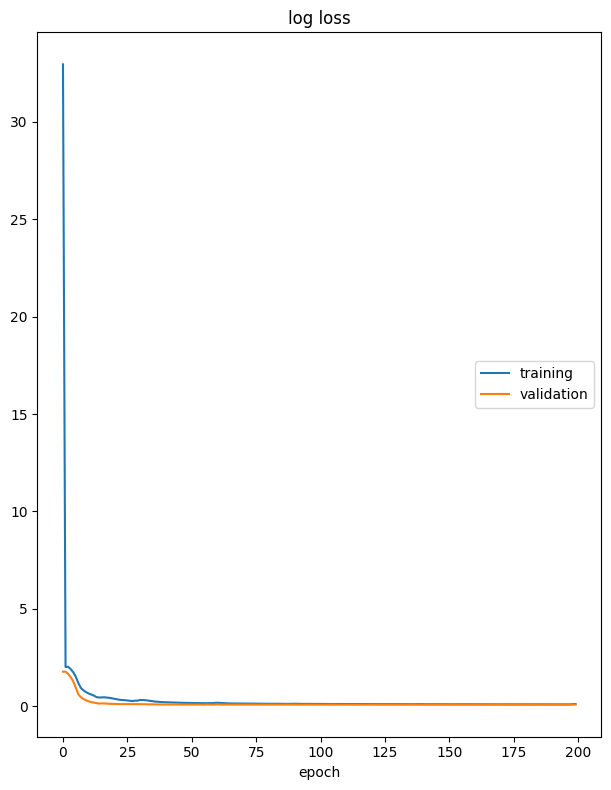

log loss
	training         	 (min:    0.089, max:   32.957, cur:    0.108)
	validation       	 (min:    0.074, max:    1.770, cur:    0.083)


In [128]:
epochs = 200

# save_path = "VAE.pth"
# try: 
#     model.load_state_dict(torch.load("VAE.pth",map_location='cpu'))
# except FileNotFoundError:

loss_function = loss_function #torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
 
mseloss = nn.BCELoss(reduction='mean')

liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    loss1 = train(model, optimizer, loss_function, trainloader, trainshiftloader, channel_size)
    
    loss2 = validate(model, loss_function, testloader,testshiftloader,channel_size)
    logs['' + 'log loss'] = loss1.item()
    logs['val_' + 'log loss'] = loss2.item()
    liveloss.update(logs)
    liveloss.draw()
    
    
        


In [131]:
nums = (torch.randn((2,64))).to(device)
samples = model.decode(nums).cpu().detach().numpy()



In [ ]:
model.

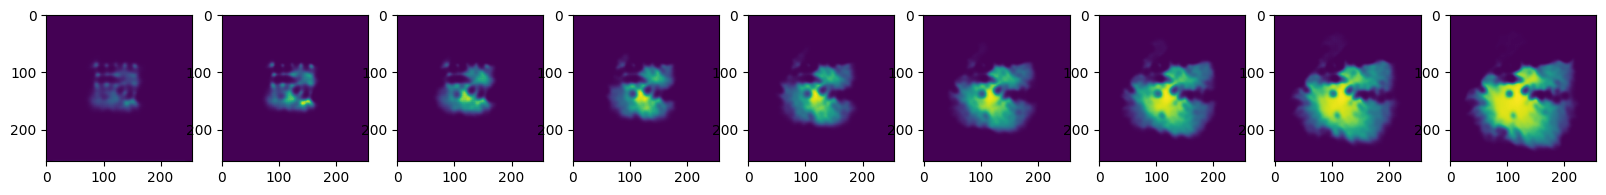

In [132]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[1].reshape(1,channel_size,256,256)[0][i*2])

plt.show()

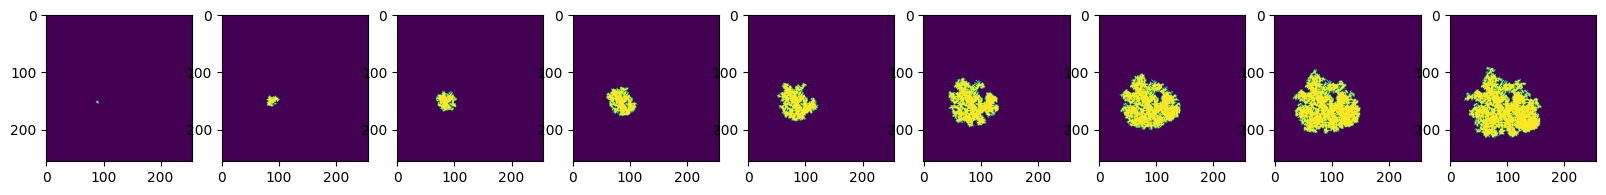

In [133]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(train_4d[100][i*2])

plt.show()

In [134]:
torch.save(model, "model.pth")